In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [63]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
str_base_path = '/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2'

In [68]:
# Proceso para saber la cantidad de imagenes cargadas para cada carpeta de train y test
import os
drive_path = '/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes'
image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
image_count_per_folder = {}

for root, dirs, files in os.walk(drive_path):
    image_files = [f for f in files if f.lower().endswith(image_extensions)]
    if image_files:
        image_count_per_folder[root] = len(image_files)

# Cantidad de imagenes para cada carpeta de imagen
for folder, count in image_count_per_folder.items():
    print(f'Carpeta: {folder}, Imágenes: {count}')


Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/preview, Imágenes: 11
Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/train_set/FreshStrawberry, Imágenes: 480
Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/train_set/FreshMango, Imágenes: 480
Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/train_set/FreshCarrot, Imágenes: 480
Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/train_set/FreshPotato, Imágenes: 479
Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/train_set/FreshBanana, Imágenes: 479
Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/train_set/FreshTomato, Imágenes: 480
Carpeta: /content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/Imagenes/test_set/FreshTomato, Imágenes: 1

Data Aumentation e input data para train

In [69]:
data_train_path = str_base_path + '/Imagenes/train_set/' # Colab
#mecanismo de data aumentation para generar variaciones en las imagener originales

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2,
                                   horizontal_flip=True, validation_split=0.2)

train_data_generator = train_datagen.flow_from_directory(
    data_train_path,  # Directorio de las imágenes
    target_size=(224, 224),  # Tamaño esperado por MobileNetV2
    batch_size=32, #Tamaño del batch de entrenamiento
    class_mode='categorical',  #problema de clasificación categorical
    subset='training') #set al que pertenece, en este caso es el problema de clasificacion


Found 2304 images belonging to 6 classes.


In [70]:
data_test_path = str_base_path + '/Imagenes/test_set/' # Colab

# solo aplicamos rescale ya que la predicción se hará sobre la misma imagen
test_data_generator = train_datagen.flow_from_directory(
    data_test_path, #dirección de las imagenes de testeo
    target_size=(224, 224), # Tamaño esperado por MobileNetV2
    batch_size=32,#Tamaño del batch de entrenamiento
    class_mode='categorical',
    subset='validation')#set al que pertenece, en este caso es el problema de testeo


Found 143 images belonging to 6 classes.


# Generación de Modelo

Para realizar el proceso de clasificación, inicialmente se partió utilizando el modelo aprendido en clase, sin embargo, este obtuvo un accuracy de 0.16. Por lo que, pudimos encontrar un análisis con Redes Neuronales Convolucionales : "deep CNN approach to detect and classify local fruits through a web interface"(https://www.sciencedirect.com/science/article/pii/S2772375523001508#bib0001). A partir de ello, pudimos conocer que habían otros mecanismos para hacer un modelo más preciso, dentro de ellos destacaron el MobilNet.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), #formato en eque estarán ingresando las imagenes
                                               include_top=False,
                                               weights='imagenet')

# Congelar las capas base para no actualizarlas durante el entrenamiento inicial
base_model.trainable = False

# Añadir capas personalizadas para la clasificación
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_data_generator.class_indices), activation='softmax')  # Número de clases, que en este caso por 6 clasificaciones, es 6
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Entrenamiento de modelo
history = model.fit(train_data_generator,
                    epochs=10, #tomando
                    validation_data=test_data_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/72 ━━━━━━━━━━━━━━━━━━━━ 5:16 8s/step - accuracy: 0.6980 - loss: 0.9087

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 620s 8s/step - accuracy: 0.8247 - loss: 0.5297 - val_accuracy: 0.9930 - val_loss: 0.0219
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9842 - loss: 0.0477 - val_accuracy: 0.9790 - val_loss: 0.0636
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9874 - loss: 0.0349 - val_accuracy: 0.9930 - val_loss: 0.0258
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9888 - loss: 0.0247 - val_accuracy: 1.0000 - val_loss: 0.0109
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9890 - loss: 0.0312 - val_accuracy: 0.9930 - val_loss: 0.0204
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9925 - loss: 0.0190 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9957 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 9.1663e-04
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9957 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss

In [ ]:
# Proceso para mejorar la presición del modelo de MobilNet
base_model.trainable = True # busca que las capas del modelo sean entrenables
fine_tune_at = 100  # Descongelar desde la capa 100

for layer in base_model.layers[:fine_tune_at]: # busca afinar el proceso, haciendo que el indice de fine_tune_at indique hasta donde se congela, lo que busca es que los pesos se actualicen
    layer.trainable = False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), #se compila nuevamente el proceso con optimizadores para el  modelo
              loss='categorical_crossentropy', # dado a que es un modelo de categorización, ya que inicialmente se utilziaba un binario
              metrics=['accuracy']) # indicador de precisión del modelo

history_fine = model.fit(train_data_generator,
                         epochs=5,
                         validation_data=test_data_generator)


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.8808 - loss: 0.6949 - val_accuracy: 0.9930 - val_loss: 0.0546
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9694 - loss: 0.1505 - val_accuracy: 0.9930 - val_loss: 0.0550
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9751 - loss: 0.0862 - val_accuracy: 0.9930 - val_loss: 0.0251
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.9835 - loss: 0.0722 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9904 - loss: 0.0264 - val_accuracy: 0.9930 - val_loss: 0.0119


In [ ]:
loss, accuracy = model.evaluate(test_data_generator) # Se obtiene el accuracy del modelo
print(f'Model Accuracy: {accuracy * 100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9868 - loss: 0.0328
Model Accuracy: 99.30%


In [ ]:
#Guardado del modelo
model.save(str_base_path + '/cnn_MobileNetV2.h5')

In [ ]:
print(test_data_generator.class_indices)

{'FreshBanana': 0, 'FreshCarrot': 1, 'FreshMango': 2, 'FreshPotato': 3, 'FreshStrawberry': 4, 'FreshTomato': 5}


In [ ]:
#Validar el orden en que se encuentran las carpetas para para definir los valores
data_dir = '/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte 2/train_set'

arr_vals = sorted(os.listdir(data_dir))
print(arr_vals) #

['FreshBanana', 'FreshCarrot', 'FreshMango', 'FreshPotato', 'FreshStrawberry', 'FreshTomato']


Predicción con imágenes nuevas

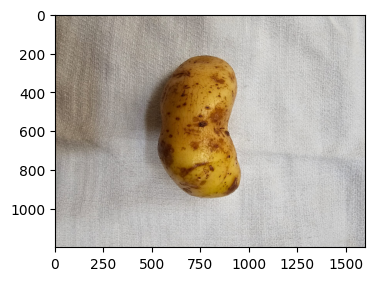

In [ ]:
import cv2
import matplotlib.pyplot as plt

predict = cv2.imread('/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte_2/Imagenes/evaluate_set/Papa.jpeg')
predict = cv2.cvtColor(predict,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4,4))
plt.imshow(predict)
plt.show()

In [ ]:
def predict_new_image(img):
  img = cv2.resize(img,(224,224))
  img = img.astype('float32')/255.
  img= np.expand_dims(img, axis=0)
  prediccion=model.predict(img)
  arr_vals = ['Banana', 'FreshCarrot', 'FreshMango', 'FreshPotato', 'FreshStrawberry', 'FreshTomato']
  pred_out = np.argmax(prediccion, axis=1)[0]
  return arr_vals[pred_out]


In [ ]:
predict_new_image(predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


'FreshPotato'

Prueba con todas las imágenes tomadas por nosotros

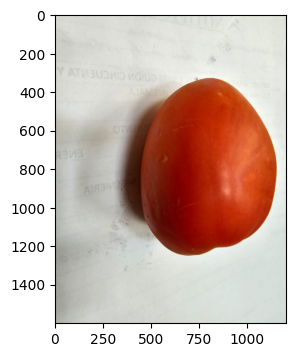

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


'FreshTomato'

In [ ]:
predict = cv2.imread('/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte_2/Imagenes/evaluate_set/Tomate.jpeg')
predict = cv2.cvtColor(predict,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4,4))
plt.imshow(predict)
plt.show()
predict_new_image(predict)

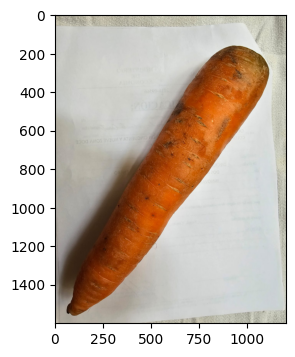

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


'FreshCarrot'

In [ ]:
predict = cv2.imread('/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte_2/Imagenes/evaluate_set/Zanahoria.jpeg')
predict = cv2.cvtColor(predict,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4,4))
plt.imshow(predict)
plt.show()
predict_new_image(predict)

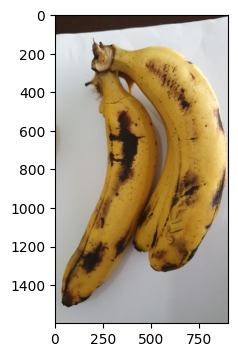

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


'Banana'

In [ ]:
predict = cv2.imread('/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte_2/Imagenes/evaluate_set/Banano.jpeg')
predict = cv2.cvtColor(predict,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4,4))
plt.imshow(predict)
plt.show()
predict_new_image(predict)

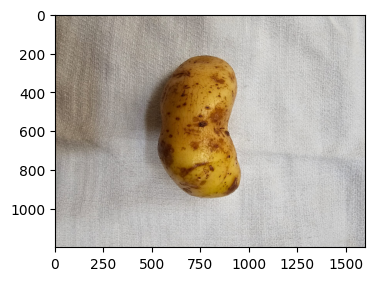

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


'FreshPotato'

In [ ]:
predict = cv2.imread('/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte_2/Imagenes/evaluate_set/Papa.jpeg')
predict = cv2.cvtColor(predict,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4,4))
plt.imshow(predict)
plt.show()
predict_new_image(predict)

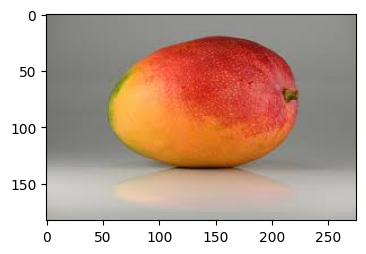

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


'FreshMango'

In [ ]:
#no teniamos mango, entonces tuvimos que sacarla de internet
predict = cv2.imread('/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte_2/Imagenes/evaluate_set/mango.jpg')
predict = cv2.cvtColor(predict,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4,4))
plt.imshow(predict)
plt.show()
predict_new_image(predict)

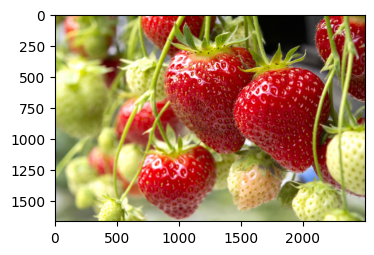

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


'FreshStrawberry'

In [ ]:
#no teniamos Fresas, entonces tuvimos que sacar la imagen de internet
predict = cv2.imread('/content/drive/MyDrive/Text Mining & Image Recognition Proyecto/Parte_2/Imagenes/evaluate_set/Fresa.jpeg')
predict = cv2.cvtColor(predict,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4,4))
plt.imshow(predict)
plt.show()
predict_new_image(predict)

#